In [2]:
!pip install pycocotools -Uqq
!pip install supervision
!pip install patchify
!pip install git+https://github.com/cocodataset/panopticapi.git

  Using cached supervision-0.25.0-py3-none-any.whl.metadata (14 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached supervision-0.25.0-py3-none-any.whl (181 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)
  Using cached patchify-0.2.3-py3-none-any.whl.metadata (3.0 kB)
Using cached patchify-0.2.3-py3-none-any.whl (6.6 kB)
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-epllq288
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-epllq288
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8258 sha256=5150be0757eea051a652aac4a1b93376f56af6db783772ea010b8a02a436c464
  Stored in d

### importing libraries

In [7]:
import json, cv2, numpy as np, itertools, random, pandas as pd
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from skimage import io
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from sklearn import model_selection
import glob
import os
import tifffile
from shapely.geometry import Polygon
import shutil
import yaml
import supervision as sv
from patchify import patchify
from panopticapi.utils import rgb2id

import matplotlib.pyplot as plt
from skimage import io
from pycocotools.coco import COCO
import matplotlib.patches as mpatches

import pycocotools.mask as mask_util
import albumentations as A

from skimage import feature
from skimage.filters import sobel
from skimage.exposure import equalize_adapthist

### Functions

In [8]:
def coordinates_to_masks(coordinates, shape):
    masks = []
    for coord in coordinates:
        mask = np.zeros(shape, dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(coord)], 1)
        masks.append(mask)
    return masks

def coordinates_to_boundary(coordinates, shape, thickness):
    masks = []
    for coord in coordinates:
        mask = np.zeros(shape, dtype=np.uint8)
        cv2.drawContours(mask, [np.array(coord)], -1, 1, thickness=thickness)
        masks.append(mask)
    return masks

def polygons_to_mask(polygons: np.ndarray, shape) -> np.ndarray:
    mask = np.zeros(shape, dtype=np.uint8)
    cv2.fillPoly(mask, polygons, color=1)
    return mask

def binary_mask_to_rle(binary_mask):
    """https://www.kaggle.com/code/alejopaullier/how-to-create-a-coco-dataset
    Checkout: https://cocodataset.org/#format-results
    :param mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    
    This function returns the following dictionary:
    {
        "counts": encoded mask suggested by the official COCO dataset webpage.
        "size": the size of the input mask/image
    }
    """
    # Create dictionary for the segmentation key in the COCO dataset
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    # We need to convert it to a Fortran array
    binary_mask_fortran = np.asfortranarray(binary_mask)
    # Encode the mask as specified by the official COCO format
    encoded_mask = mask_util.encode(binary_mask_fortran)
    # We must decode the byte encoded string or otherwise we cannot save it as a JSON file
    rle["counts"] = encoded_mask["counts"].decode()
    return rle

def rle_to_binary_mask(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) 
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def slide_image(img):
    """Inference by sliding-window with overlap.

    If h_crop > h_img or w_crop > w_img, the small patch will be used to
    decode without padding.
    """

    h_stride, w_stride = CFG.stride
    h_crop, w_crop = CFG.crop
    
    if len(img.shape) == 3:
        img_type = "rgb"
        h_img, w_img = img.shape[:2]
    else:
        img_type = "mask"
        h_img, w_img = img.shape
    
    h_grids = max(h_img - h_crop + h_stride - 1, 0) // h_stride + 1
    w_grids = max(w_img - w_crop + w_stride - 1, 0) // w_stride + 1    
    if img_type == "rgb":
        imgs = np.zeros((h_grids * w_grids, h_crop, w_crop, img.shape[-1]))
    else:
        imgs = np.zeros((h_grids * w_grids, h_crop, w_crop))
    
    idx = 0
    for h_idx in range(h_grids):
        for w_idx in range(w_grids):
            y1 = h_idx * h_stride
            x1 = w_idx * w_stride
            y2 = min(y1 + h_crop, h_img)
            x2 = min(x1 + w_crop, w_img)
            y1 = max(y2 - h_crop, 0)
            x1 = max(x2 - w_crop, 0)
            if img_type == "rgb":
                imgs[idx] = img[y1:y2, x1:x2, :]
            else:
                imgs[idx] = img[y1:y2, x1:x2]
            idx += 1

    return imgs

### CFG

In [9]:
class CFG:
    n_splits = 3
    select_fold = 0
    use_channel = "all"
    cut_value = [50, 2500]
    dataset_type = "semantic" # panoptic semantic instance_split instance
    add_canny = False
    thickness = 1
    random_state = 71
    
    if dataset_type == "semantic":
        image_suffix = "tif"
    else:
        image_suffix = "jpg"
        
    stride = 512, 512
    crop = 512, 512
    
    
# -------------------------
cfg = yaml.safe_load(f"""
n_splits: {CFG.n_splits}
select_fold: {CFG.select_fold}
use_channel: {CFG.use_channel}
image_suffix: {CFG.image_suffix}
cut_value: {CFG.cut_value}
dataset_type: {CFG.dataset_type}
thickness: {CFG.thickness}
random_state: {CFG.random_state}
""")

with open("preprocessed_data/cfg.yaml", "w") as yf:
    yaml.dump(cfg, yf, default_flow_style=False)

### data path

In [11]:
train_img_dir = '../data/train_images/'
test_img_dir = '../data/test_images/'

ann_path = '../data/train_annotation.json'
sample_path = '../data/test_annotation.json'

# -----------------------------------------------------------------------------
BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
CMAPS = ['Blues', 'Greens', 'Reds', 'Purples']
CMAPS = CMAPS + CMAPS + CMAPS
COLORS = ['blue', 'green', 'red', 'purple']
COLORS = COLORS + COLORS + COLORS

### define path

In [13]:
train_img_name_arr = np.array(os.listdir(train_img_dir))
num_img = np.array([int(_.rstrip('.tif').split('_')[-1]) for _ in train_img_name_arr])
train_img_names = train_img_name_arr[np.argsort(num_img)].tolist()

test_img_name_arr = np.array(os.listdir(test_img_dir))
num_img = np.array([int(_.rstrip('.tif').split('_')[-1]) for _ in test_img_name_arr])
test_img_names = test_img_name_arr[np.argsort(num_img)].tolist()

print(len(train_img_names), train_img_names[:2])
print(len(test_img_names), test_img_names[:2])

50 ['train_0.tif', 'train_1.tif']
50 ['test_0.tif', 'test_1.tif']


### Sample Data

In [14]:
def convert_rgb(image, cut_value):
    
    if image.shape[-1] >= 4:
        R = np.clip(image[:, :, 3], cut_value[0], cut_value[1]) / cut_value[1] * 255
        G = np.clip(image[:, :, 2], cut_value[0], cut_value[1]) / cut_value[1] * 255
        B = np.clip(image[:, :, 1], cut_value[0], cut_value[1]) / cut_value[1] * 255
    else:
        R = np.clip(image[:, :, 2], cut_value[0], cut_value[1]) / cut_value[1] * 255
        G = np.clip(image[:, :, 1], cut_value[0], cut_value[1]) / cut_value[1] * 255
        B = np.clip(image[:, :, 0], cut_value[0], cut_value[1]) / cut_value[1] * 255
    
    rgb_image = np.stack((R, G, B), axis=2).astype(np.uint8)
    rgb_image = Image.fromarray(rgb_image)
    return rgb_image

def get_unique_rgb(img):

    reshaped_bgr_array = img.reshape(img.shape[0]*img.shape[1], 3)

    # axis=0で行方向のユニーク化を指定
    unique_bgr_array = np.unique(reshaped_bgr_array, axis=0)

    # ユニークなbgr値の一覧
    return unique_bgr_array

(dtype('float64'), (803, 1008, 12))

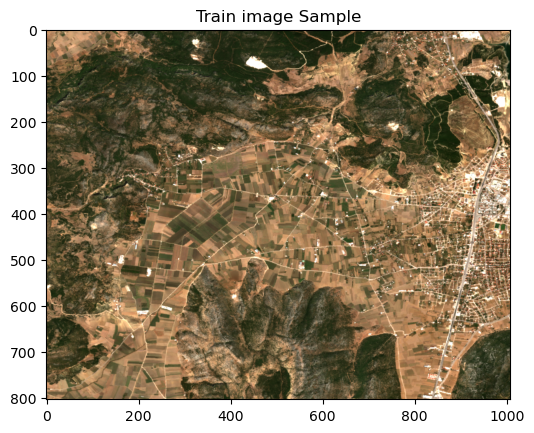

In [15]:
PATH_SAMPLE = f'{train_img_dir}/train_1.tif' # train_38
imgs = tifffile.imread(PATH_SAMPLE)
isnan = np.isnan(imgs)
mask = np.zeros(imgs.shape[:2])
# mask[isnan[..., 0]] = 1

plt.imshow(convert_rgb(imgs, CFG.cut_value))
plt.title('Train image Sample')

imgs.dtype, imgs.shape

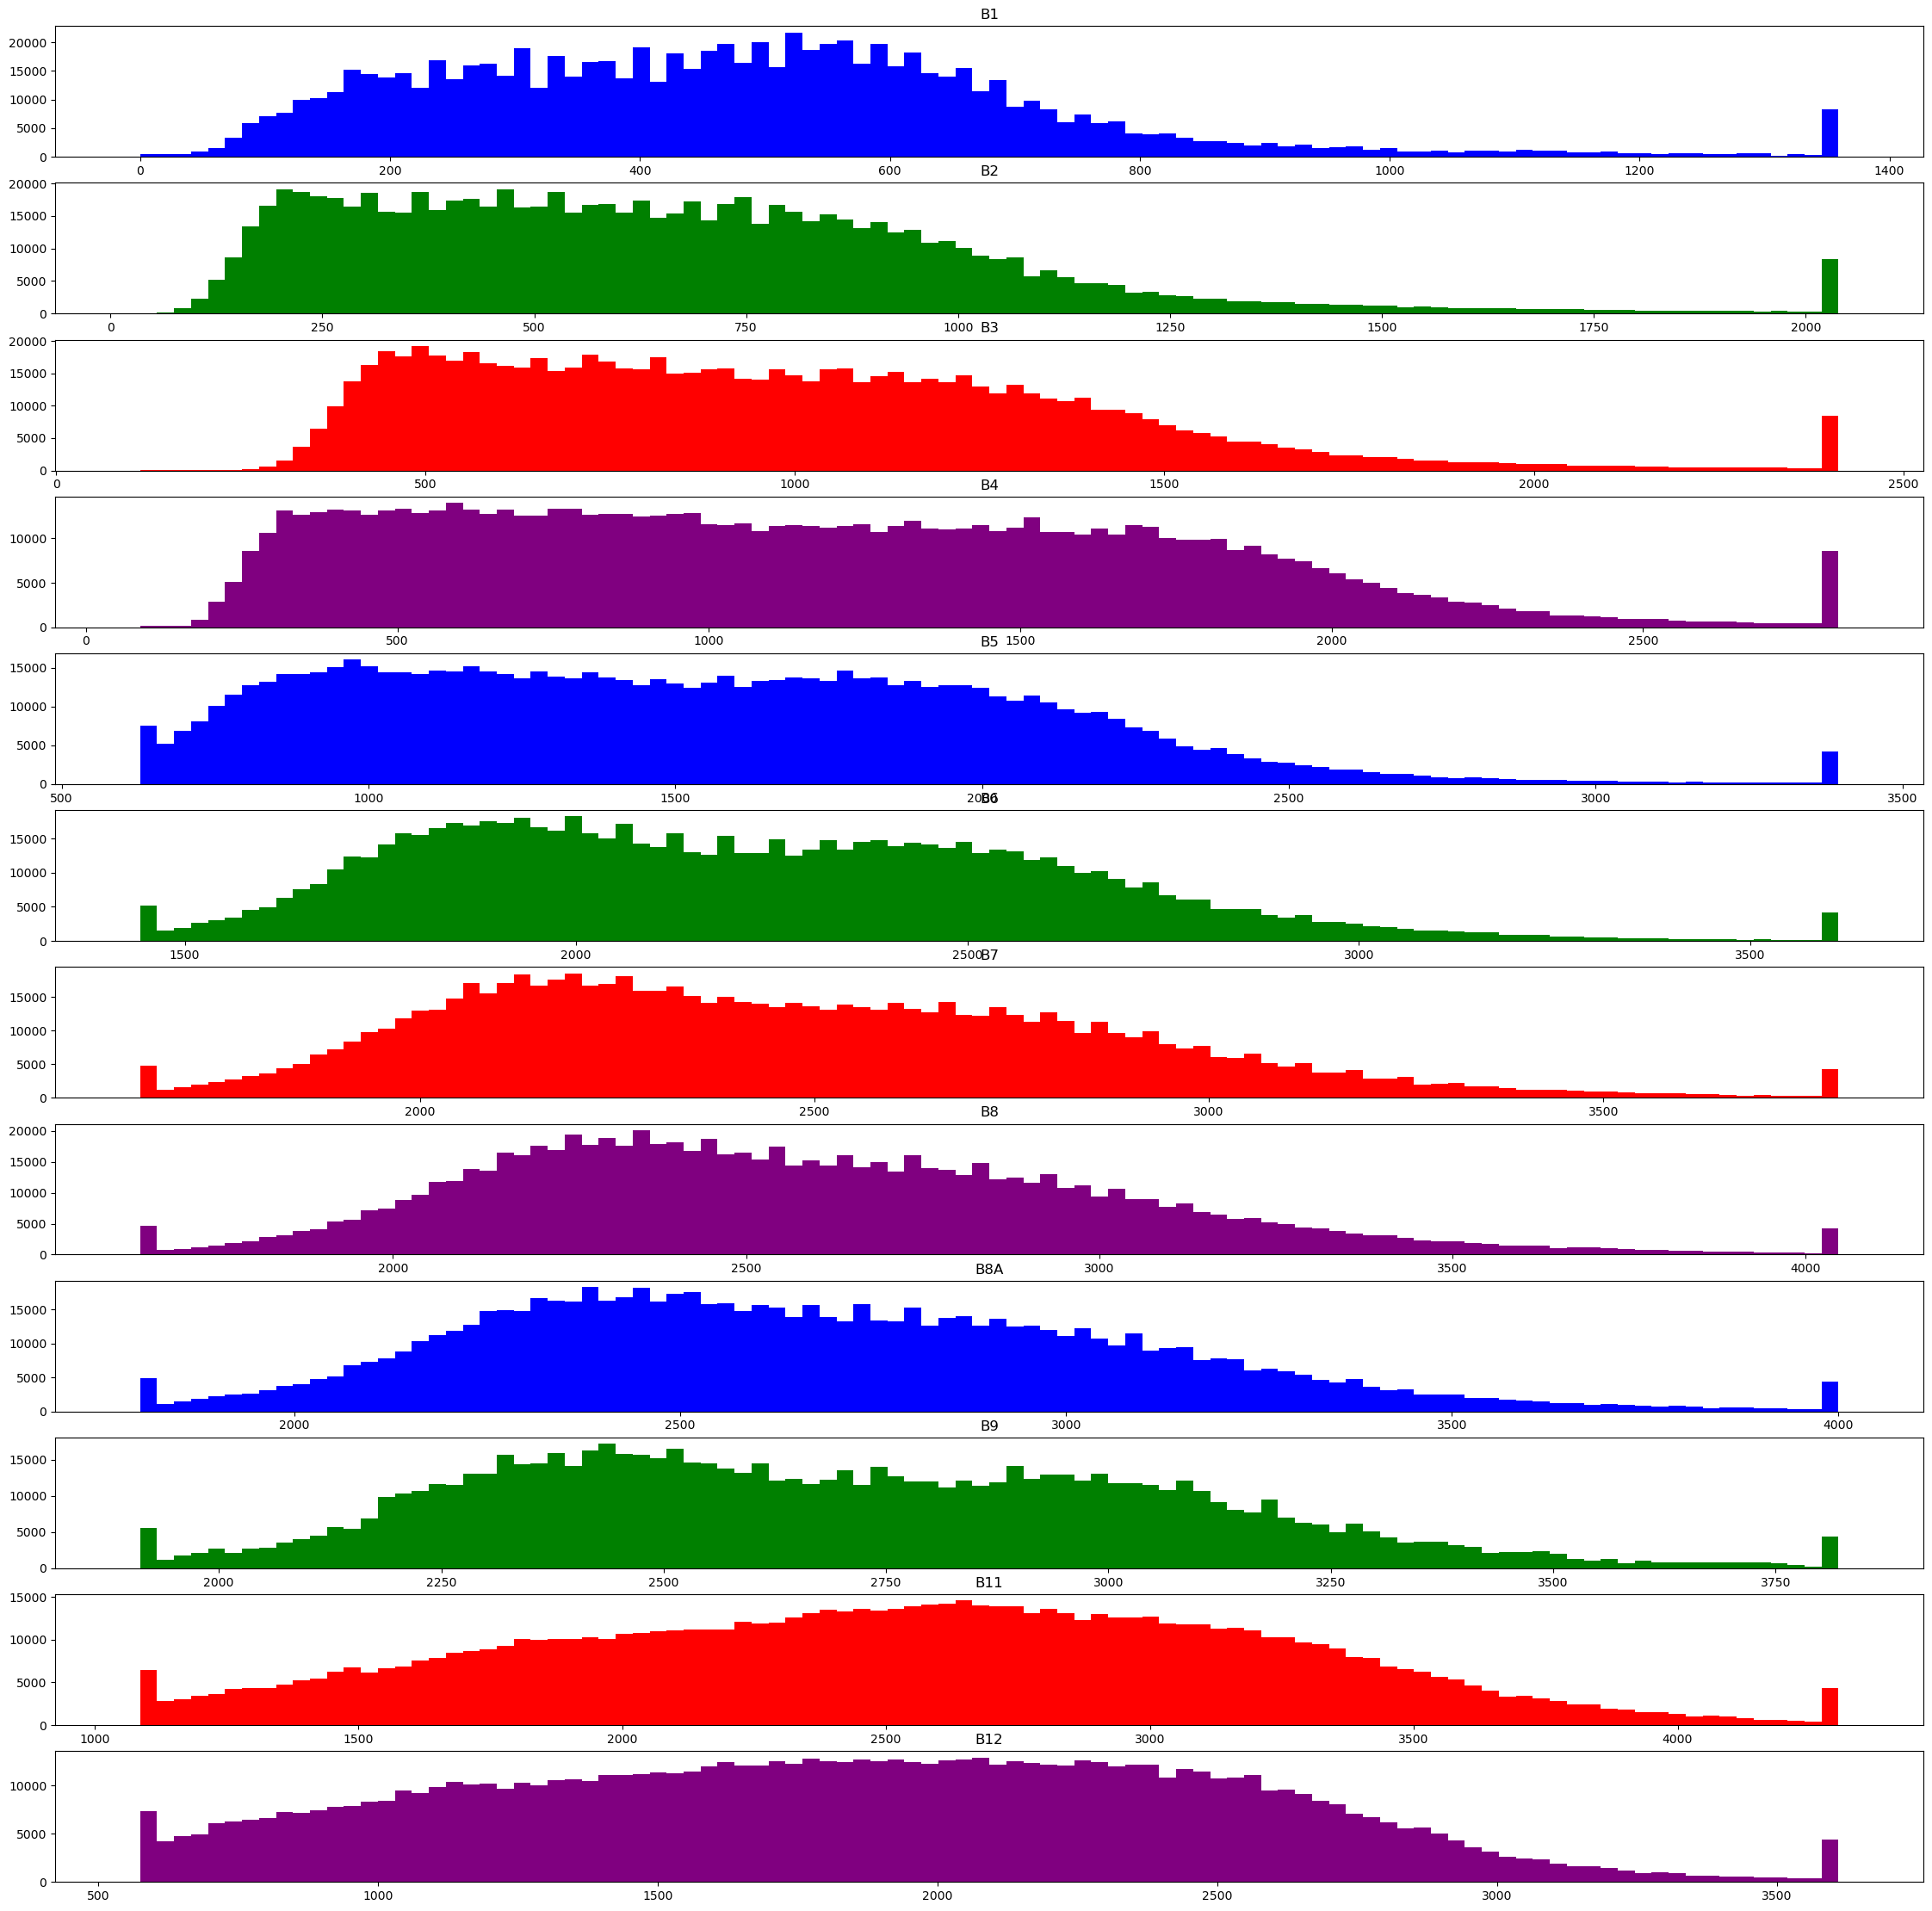

In [16]:
quantile_clips = [[0.000, 0.990] for _ in range(4)] + [[0.005, 0.995] for _ in range(8)]

# fillna
isnan = np.isnan(imgs)
if isnan.sum() > 0:
    imgs[isnan] = imgs[~isnan].min()     

plt.figure(figsize=(28, 28))
for i, (b, c) in enumerate(zip(BANDS, COLORS)):
    img = imgs[:, :, i].copy()
    
    a_min, a_max = np.quantile(a=img, q=quantile_clips[i], axis=(0, 1))
    img = np.clip(a=img, a_min=a_min, a_max=a_max)
    
    #img = np.log10(1+img)
    
    plt.subplot(imgs.shape[-1], 1, BANDS.index(b) + 1)
    plt.hist(img.flatten(), color=c, bins=100) # range=(300, 5000) , bins=200,range=(0., 1.)
    plt.title(b)

### Stat

In [17]:
class WavelengthBlend:
    def __init__(self, combs):
        self.combs = combs

    def calc(self, imgs):
        
        feats = []
        for comb in self.combs:
            if len(comb) == 2:
                feat = self.d2(
                    imgs[..., comb[0]], imgs[..., comb[1]]
                )
            elif len(comb) == 3:
                feat = self.d3(
                    imgs[..., comb[0]], imgs[..., comb[1]], imgs[..., comb[2]]
                )
            elif len(comb) == 4:
                feat = self.d4(
                    imgs[..., comb[0]], imgs[..., comb[1]], imgs[..., comb[2]], imgs[..., comb[3]]
                )
            else:
                raise
            feats.append(feat)
        
        return np.concatenate([imgs, np.stack(feats, axis=2)], axis=2)
    
    def d2(self, x1, x2):
        out = (x1 - x2) / (x1 + x2)
        out = np.where(np.isnan(out), 0, out)
        return out

    def d3(self, x1, x2, x3):
        out = (x1 - x2) / (x1 + x3)
        out = np.where(np.isnan(out), 0, out)
        return out

    def d4(self, x1, x2, x3, x4):
        out = (x1 - x2) / (x1 + x3)
        out = ((x1 - x2) - (x3 + x4))/(x1 + x2 + x3 + x4)
        out = np.where(np.isnan(out), 0, out)
        return out

In [18]:
combs = [
    [3, 2],  # (R-G)/(R+G)
    [2, 1],  # (G-B)/(G+B)
    [7, 3],  # NDVI (band8-band4)/(band8+band4)
    [3, 7],  # NDVI (band8-band4)/(band8+band4)
    [2, 7],  # NDWI (B03 - B08) / (B03 + B08)
    [2, 10], # NDSI (B03 - B11) / (B03 + B11)
    [7, 10], # NDMI = (B08 - B11) / (B08 + B11)
    [7, 11], # NBR = (B08 - B12) / (B08 + B12)
    [10, 11], # (band11-band12)/(band11+band12) 
    [3, 1, 2], # (R-B)/(R+G) 
    [7, 9, 10, 11], # ((band8-band9)-(band11+band12))/(band8+band9+band11+band11+band12)
]

In [19]:
def static_image(path, names, quantile_clips, add_index_feat=True):
    BANDS_means, BANDS_stds = [], []
    BANDS_maxs, BANDS_mins = [], []
    BANDS_medians = []
    heights, widths = [], [] 
    for IDX in tqdm(range(len(names))):
        imgs = tifffile.imread(f'{path}/{names[IDX]}')
        
        # fillna
        isnan = np.isnan(imgs)
        if isnan.sum() > 0:
            imgs[isnan] = imgs[~isnan].min()
        
        # Quantile Clip
        if quantile_clips:
            for _ in range(imgs.shape[-1]):
                a_min, a_max = np.quantile(a=imgs[..., _], q=quantile_clips[_], axis=(0, 1))
                imgs[..., _] = np.clip(a=imgs[..., _], a_min=a_min, a_max=a_max)
        
        height, width = imgs.shape[:2]
        
        if add_index_feat:
            wb = WavelengthBlend(combs)
            imgs = wb.calc(imgs)
        if CFG.add_canny:
            edges = feature.canny(np.array(convert_rgb(imgs, CFG.cut_value).convert("L")), sigma=CFG.add_canny).astype(np.float32)
            edges = edges * 255
            imgs = np.concatenate([imgs, np.expand_dims(edges, axis=2)], axis=2)
        
        # save images
        if CFG.image_suffix == "tif":
            if CFG.use_channel is list:
                tifffile.imwrite(f"preprocessed_data/images/{names[IDX]}", imgs[..., CFG.use_channel])
            else:
                tifffile.imwrite(f"preprocessed_data/images/{names[IDX]}", imgs)
        else:
            imgs = convert_rgb(imgs, CFG.cut_value)
            name = names[IDX].replace(".tif", f".{CFG.image_suffix}")
            imgs.save(f"preprocessed_data/images/{name}")
            imgs = np.array(imgs)
        
        BANDS_mean = np.mean(imgs, axis=(0, 1))
        BANDS_std = np.std(imgs, axis=(0, 1))
        BANDS_max = np.max(imgs, axis=(0, 1))
        BANDS_min = np.min(imgs, axis=(0, 1))
        BANDS_median = np.median(imgs, axis=(0, 1))
        
        BANDS_means.append(BANDS_mean), BANDS_stds.append(BANDS_std)
        BANDS_maxs.append(BANDS_max), BANDS_mins.append(BANDS_min)
        BANDS_medians.append(BANDS_median)
        heights.append(height), widths.append(width)
        
    BANDS_means_ = np.mean(BANDS_means, axis=0)
    BANDS_stds_ = np.mean(BANDS_stds, axis=0)
    BANDS_mins_ = np.mean(BANDS_mins, axis=0)
    BANDS_maxs_ = np.mean(BANDS_maxs, axis=0)
    BANDS_medians_ = np.mean(BANDS_medians, axis=0)
    
    BANDS_static = BANDS_means_, BANDS_stds_, BANDS_mins_, BANDS_maxs_, BANDS_medians_
    for idx, (m, s, mi, ma, me) in enumerate(zip(BANDS_means_, BANDS_stds_, BANDS_mins_, BANDS_maxs_, BANDS_medians_)):
        print(f'{idx}: {m:.5f} +- {s:.5f}  [min {mi:.5f} ~ max {ma:.5f}] [{me:.5f}]')
    
    size = widths, heights
    return BANDS_static, size

In [20]:
calc_static = True
os.makedirs("preprocessed_data/calc_static", exist_ok=True)
os.makedirs("preprocessed_data/images", exist_ok=True)

if calc_static:
    
    print('--- Train ---')
    BANDS_static_train, size_train = static_image(train_img_dir, train_img_names, quantile_clips)

    print('--- Test ---')
    BANDS_static_test, size_test = static_image(test_img_dir, test_img_names, quantile_clips)
    
    pd.DataFrame(BANDS_static_train, index=['mean', 'std', 'min', 'max', 'median']).T.to_csv('preprocessed_data/calc_static/train_statistics.csv', index=False)
    pd.DataFrame(BANDS_static_test, index=['mean', 'std', 'min', 'max', 'median']).T.to_csv('preprocessed_data/calc_static/test_statistics.csv', index=False)
    pd.DataFrame(size_train, index=['width', 'height']).T.to_csv('preprocessed_data/calc_static/train_size.csv', index=False)
    pd.DataFrame(size_test, index=['width', 'height']).T.to_csv('preprocessed_data/calc_static/test_size.csv', index=False)

else:
    raise

--- Train ---


  0%|          | 0/50 [00:00<?, ?it/s]

0: 467.30092 +- 152.75775  [min 142.57254 ~ max 988.76548] [444.33525]
1: 602.04754 +- 219.01552  [min 129.68203 ~ max 1343.31279] [565.99697]
2: 899.10973 +- 264.75055  [min 208.71795 ~ max 1734.10576] [869.12090]
3: 1024.38565 +- 390.51910  [min 155.19585 ~ max 2122.39831] [980.58593]
4: 1435.75861 +- 367.77475  [min 663.26012 ~ max 2609.27029] [1419.76900]
5: 2311.89481 +- 415.03720  [min 1143.57607 ~ max 3417.31987] [2325.63628]
6: 2615.70841 +- 488.53910  [min 1272.52067 ~ max 3928.52005] [2622.18500]
7: 2762.81409 +- 533.87545  [min 1256.72582 ~ max 4168.89795] [2773.75664]
8: 2846.26383 +- 519.97376  [min 1383.28906 ~ max 4186.74977] [2858.93850]
9: 2875.30292 +- 478.57237  [min 1586.09807 ~ max 4097.78402] [2887.59067]
10: 2444.92475 +- 515.24588  [min 1154.60017 ~ max 3798.72649] [2441.65667]
11: 1771.52122 +- 528.09513  [min 653.39833 ~ max 3270.30556] [1739.01600]
12: 0.02629 +- 0.08926  [min -0.42403 ~ max 0.38411] [0.04275]
13: 0.20923 +- 0.05593  [min -0.10607 ~ max 0.492

  0%|          | 0/50 [00:00<?, ?it/s]

0: 469.85021 +- 136.01099  [min 146.32833 ~ max 934.75365] [455.22757]
1: 601.73984 +- 190.28934  [min 127.89670 ~ max 1237.35731] [581.37180]
2: 881.93939 +- 223.73562  [min 208.57238 ~ max 1571.32540] [868.60305]
3: 1017.38709 +- 323.83742  [min 168.64127 ~ max 1918.44847] [995.70533]
4: 1423.10101 +- 305.06770  [min 679.49794 ~ max 2367.13455] [1423.01300]
5: 2246.08262 +- 402.68884  [min 1064.38527 ~ max 3297.04394] [2260.26667]
6: 2531.36540 +- 482.26860  [min 1181.16583 ~ max 3812.41197] [2533.04817]
7: 2680.74537 +- 533.31093  [min 1151.04987 ~ max 4072.05418] [2686.08000]
8: 2764.85043 +- 518.15760  [min 1278.53621 ~ max 4084.07917] [2772.05452]
9: 2792.36383 +- 471.40002  [min 1517.58167 ~ max 3997.12231] [2798.26833]
10: 2474.06107 +- 447.88514  [min 1180.46102 ~ max 3593.35028] [2483.89452]
11: 1809.02211 +- 452.15750  [min 727.67195 ~ max 3059.71773] [1792.83125]
12: 0.03120 +- 0.07937  [min -0.41063 ~ max 0.42527] [0.04264]
13: 0.20665 +- 0.05396  [min -0.13410 ~ max 0.497

### Reading polygons.jsonl

In [21]:
with open(ann_path, "r") as file:
    ann = json.load(file)

In [22]:
file_names = []
areas = []
areas_mean = []
areas_min = []
areas_max = []
areas_max = []
ins_len = []
classes = []
segmentations = []
for aa in ann['images']:
    file_names.append(aa['file_name'])
    
    area = 0
    class_list = []
    segmentation_list = []
    area_list = []
    for a in aa['annotations']:
        p = Polygon(np.array(a['segmentation']).reshape(-1, 2)) # .buffer(0)
        area_list.append(p.area)
        class_list.append(a['class'])
        segmentation_list.append(a['segmentation'])
        
    area = sum(area_list)
    area_mean = np.mean(area_list)
    area_min = min(area_list)
    area_max = max(area_list)
    
    areas.append(area)
    areas_mean.append(area_mean)
    areas_min.append(area_min)
    areas_max.append(area_max)
    ins_len.append(len(area_list))
    classes.append(set(class_list))
    segmentations.append(segmentation_list)

ann_df = pd.DataFrame(
    [file_names, areas, areas_mean, areas_min, areas_max, ins_len, classes, segmentations], 
    index=["file_name", "area", "area_mean", "area_min", "area_max", "ins_len", "class", "segmentations"]).T

bin_col = "ins_len" # area
ann_df[f"{bin_col}_bin"] = pd.cut(ann_df[bin_col], bins=3, labels=False)
print(dict(ann_df[f"{bin_col}_bin"].value_counts()))

# Add Shape
size_train_df = pd.DataFrame(size_train, index=['width', 'height']).T
ann_df = pd.concat([ann_df, size_train_df], axis=1)

{0: 39, 1: 7, 2: 4}


### kmeans by a image

  0%|          | 0/50 [00:00<?, ?it/s]

ret: 609129664.46, label: (937538,), center: (3, 3), mode_color: [115 102  67]


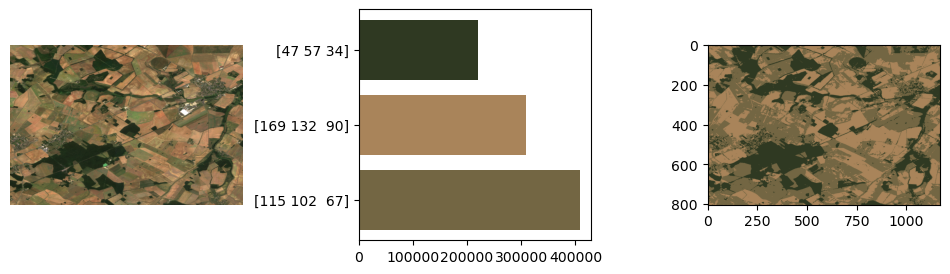

ret: 30454.30, label: (50, 1), center: (3, 3)


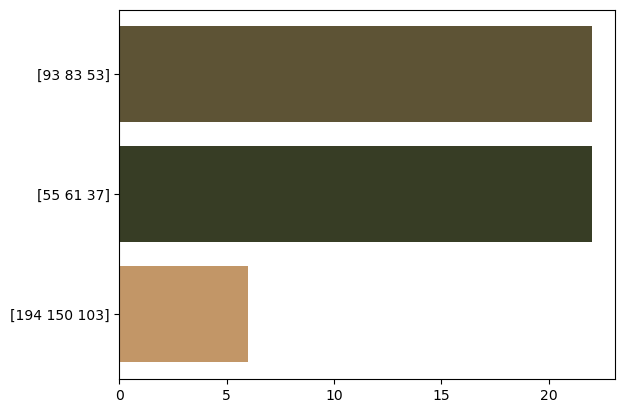

{2: 22, 1: 22, 0: 6}


In [23]:
if calc_static:

    mode_colors = []
    centers_list = []
    for IDX in tqdm(range(len(train_img_names))):

        # 画像を読み込む。
        imgs = tifffile.imread(f'{train_img_dir}/{train_img_names[IDX]}')

        # fillna
        isnan = np.isnan(imgs)
        if isnan.sum() > 0:
            imgs[isnan] = imgs[~isnan].min()

        # To RGB
        rgb = convert_rgb(imgs, CFG.cut_value)
        img = np.array(rgb)

        # 画像で使用されている色一覧。(W * H, 3) の numpy 配列。
        colors = img.reshape(-1, 3).astype(np.float32)

        # クラスタ数
        K = 3

        # 最大反復回数: 10、移動量の閾値: 1.0
        criteria = cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1.0

        ret, labels, centers = cv2.kmeans(
            colors, K, None, criteria, attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS
        )

        labels = labels.squeeze(axis=1)  # (N, 1) -> (N,)
        centers = centers.astype(np.uint8)  # float32 -> uint8

        # 各クラスタに属するサンプル数を計算する。
        uni, counts = np.unique(labels, axis=0, return_counts=True)
        mode_color = centers[np.argmax(counts)]

        mode_colors.append(mode_color)
        centers_list.append(centers)

        # if IDX >= 5: break

    print(f"ret: {ret:.2f}, label: {labels.shape}, center: {centers.shape}, mode_color: {mode_color}")

    # 可視化する。
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 3))
    fig.subplots_adjust(wspace=0.5)

    # matplotlib の引数の仕様上、[0, 1] にして、(R, G, B) の順番にする。
    bar_color = centers[:, :] / 255
    bar_text = list(map(str, centers))

    # 画像を表示する。
    ax1.imshow(img)
    ax1.set_axis_off()

    # ヒストグラムを表示する。
    ax2.barh(np.arange(K), counts, color=bar_color, tick_label=bar_text)

    # 各画素を k平均法の結果に置き換える。
    dst = centers[labels].reshape(img.shape)
    ax3.imshow(dst)

    plt.show()


    # リストをndarrayに変換
    rgb_modes = np.array(mode_colors, dtype=np.float32)

    # クラスタ数
    # K = 5

    # 最大反復回数: 10、移動量の閾値: 1.0
    criteria = cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1.0

    ret, labels, centers = cv2.kmeans(
        rgb_modes, K, None, criteria, attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS
    )

    print(f"ret: {ret:.2f}, label: {labels.shape}, center: {centers.shape}")

    labels = labels.squeeze(axis=1)  # (N, 1) -> (N,)
    centers = centers.astype(np.uint8)  # float32 -> uint8
    uni, counts = np.unique(labels, axis=0, return_counts=True)

    # ヒストグラムを表示する。
    bar_color = (centers[:, :] / 255)
    bar_text = list(map(str, centers.astype(np.uint8)))

    plt.barh(np.arange(K), counts, color=bar_color, tick_label=bar_text)
    plt.show()

    ann_df["kmeans"] = labels
    print(dict(ann_df["kmeans"].value_counts()))
    
else:
    raise

In [24]:
ann_df.drop("segmentations", axis=1)

,file_name,area,area_mean,area_min,area_max,ins_len,class,ins_len_bin,width,height,kmeans
0,train_0.tif,642645.492719,957.74291,11.845641,23061.417888,671,{field},0,981,804,2
1,train_1.tif,158414.240634,159.370463,10.278948,1470.764128,994,{field},0,1008,803,1
2,train_2.tif,414203.481623,640.190853,20.49764,10629.714971,647,{field},0,978,804,0
3,train_3.tif,562798.27314,1863.570441,23.568382,7322.241854,302,{field},0,952,804,2
4,train_4.tif,808728.110965,16848.502312,519.925046,74679.180571,48,{field},0,1199,802,1
5,train_5.tif,715845.754092,874.04854,13.62754,5870.848049,819,{field},0,1206,802,2
6,train_6.tif,457682.602727,1250.498915,56.419988,9908.066991,366,{field},0,1067,803,1
7,train_7.tif,388950.303772,486.18788,32.985347,5160.955228,800,{field},0,1065,803,1
8,train_8.tif,655938.801713,570.877982,9.602786,6148.816203,1149,{field},1,1170,802,2
9,train_9.tif,761063.964867,10284.648174,159.940189,59313.661946,74,{field},0,1053,803,2


### MultilabelStratifiedKFold

In [27]:
!pip -q install iterative-stratification

In [28]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

ann_df["fold"] = 999
mskf = MultilabelStratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.random_state)
for fold, (train_idx, val_idx) in enumerate(mskf.split(X=ann_df, y=ann_df[[f"{bin_col}_bin", "kmeans"]])):
    ann_df.iloc[val_idx, -1] = fold

ann_df.to_csv('preprocessed_data/ann_meta.csv', index=False)

ann_train = ann_df[ann_df["fold"] != CFG.select_fold].copy()
ann_valid = ann_df[ann_df["fold"] == CFG.select_fold].copy()

print("ann_train", len(ann_train))
print("ann_valid", len(ann_valid))

ann_train 33
ann_valid 17


### Categories

In [29]:
categories_list = ['field']
#------------------------------------------------------------------------------
categories_ids = {name:id+1 for id, name in enumerate(categories_list)}  
ids_categories = {id+1:name for id, name in enumerate(categories_list)}  
categories =[{'id':id,'name':name} for name,id in categories_ids.items()]

print(categories_ids)
print(ids_categories)
print(categories)

{'field': 1}
{1: 'field'}
[{'id': 1, 'name': 'field'}]


### Creating COCO

In [30]:
def coco_structure(df):
    idx=1
    annotations=[]
    images=[]
    for ans in tqdm(df[["file_name", "segmentations", "width", "height"]].values):
        file_name, segmentations, width, height = ans
        image_id = file_name.replace(".tif", "")        
        image = {"id": image_id, "file_name": f"{image_id}.{CFG.image_suffix}", "height": height, "width": width}
        images.append(image)
        #-----------------------------
        for an in segmentations:
                        
            # segmentation
            segmentation = [round(_, 1) for _ in an]
            
            # bbox
            p = Polygon(np.array(an).reshape(-1, 2))
            xmin, ymin, xmax, ymax = p.bounds
            x1, x2 = xmin, xmax
            y1, y2 = ymin, ymax
            
            # area
            area = p.area
                       
            seg = {
                "id": idx,
                "image_id": image_id,
                "category_id": categories_ids["field"],
                "segmentation": [segmentation],
                "bbox": [int(x1), int(y1), int(x2 - x1 + 1), int(y2 - y1 + 1)],
                "area": int(area),
                "iscrowd": 0,
            }
            annotations.append(seg)
            idx = idx + 1
        
        # save mask
        coordinates = [np.array(_).reshape(-1, 2).astype(int) for _ in segmentations]
        masks = coordinates_to_masks(coordinates, (height, width))
        # np.save(f'/maskss/{image_id}', masks)
        
        mask = np.where(np.sum(masks, axis=0) > 0, 1, 0)
        np.save(f'preprocessed_data/masks/{image_id}', mask)
        pil_mask = Image.fromarray(np.stack([mask * 255] * 3, axis=2).astype(np.uint8))
        pil_mask.save(f'preprocessed_data/pil_mask/{image_id}.png')
        
        masks = coordinates_to_boundary(coordinates, (height, width), thickness=CFG.thickness)
        mask = np.where(np.sum(masks, axis=0) > 0, 1, 0)
        np.save(f'preprocessed_data/masks_boundary/{image_id}', mask)
        pil_mask = Image.fromarray(np.stack([mask * 255] * 3, axis=2).astype(np.uint8))
        pil_mask.save(f'preprocessed_data/pil_mask_boundary/{image_id}.png')
        
    return {"info": {}, "licenses": [], "categories": categories, "images": images, "annotations": annotations}

In [31]:
# os.makedirs("/maskss", exist_ok=True)
os.makedirs("preprocessed_data/pil_mask", exist_ok=True)
os.makedirs("preprocessed_data/pil_mask_boundary", exist_ok=True)
os.makedirs("preprocessed_data/masks", exist_ok=True)
os.makedirs("preprocessed_data/masks_boundary", exist_ok=True)

train_coco_data = coco_structure(ann_train)
valid_coco_data = coco_structure(ann_valid)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [32]:
os.makedirs('preprocessed_data/images', exist_ok=True)
os.makedirs('preprocessed_data/test', exist_ok=True)

for file_name in tqdm(ann_df["file_name"]):
    file_name_ = file_name.replace(".tif", "")
    if CFG.image_suffix == "tif":
        image = tifffile.imread(f'preprocessed_data/images/{file_name_}.{CFG.image_suffix}')
    else:
        image = cv2.imread(f'preprocessed_data/images/{file_name_}.{CFG.image_suffix}')
    mask = np.load(f'preprocessed_data/masks/{file_name_}.npy')
    mask_bound = np.load(f'preprocessed_data/masks_boundary/{file_name_}.npy')

    # ins_len = ann_df[ann_df["file_name"] == file_name]["ins_len"].iloc[0]
    np.savez(f'preprocessed_data/images/{file_name_}', image=image, mask=mask, mask_bound=mask_bound)

for file_name in tqdm(test_img_names):
    file_name_ = file_name.replace(".tif", "")
    if CFG.image_suffix == "tif":
        image = tifffile.imread(f'preprocessed_data/images/{file_name_}.{CFG.image_suffix}')
    else:
        image = cv2.imread(f'preprocessed_data/images/{file_name_}.{CFG.image_suffix}')
    np.savez(f'preprocessed_data/test/{file_name_}', image=image, mask=np.zeros(image.shape[:2]))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Visualization

UnpicklingError: Failed to interpret file 'preprocessed_data/images/train_9.tif' as a pickle

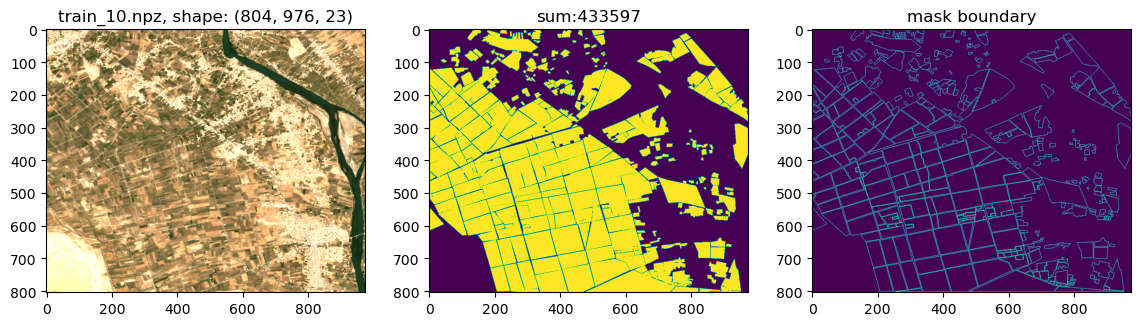

<Figure size 1400x800 with 0 Axes>

In [ ]:
for file_name in [_ for _ in os.listdir("preprocessed_data/images") if "train" in _]:

    plt.figure(figsize=(14, 8))

    npz = np.load(f'preprocessed_data/images/{file_name}', allow_pickle=True)
    image = npz["image"]
    mask = npz["mask"]
    mask_bound = npz["mask_bound"]

    if CFG.image_suffix == "tif":
        rgb = convert_rgb(image, CFG.cut_value)
    else:
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, 1)
    plt.imshow(rgb)
    plt.title(f'{file_name}, shape: {image.shape}')

    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title(f'sum:{np.sum(mask)}')

    plt.subplot(1, 3, 3)
    plt.imshow(mask_bound)
    plt.title('mask boundary')